# TC 3006B Inteligencia artificial avanzada para la ciencia de datos I
# CIFAR-10 Data Preparation (PyTorch)
## Equipo:
Jesus Ramirez Delgado - A01274723

Grant Nathaniel Keegan - A01700753

Luis Adrián Uribe Cruz - A01783129


## Feedback

## Deep Learning -- Data Cleaning

### Objective: Load CIFAR-10, explore data, compute per-channel statistics (mean & std), normalize images, and verify normalization.

### Instructions
- Focus on data preparation, analysis, data is not usually as nice as CIFAR10 is. Model training follows as explained in classes.
- Write comments and reflections in the indicated, verify you answer questions in Markdown cells.
- Keep your code clean, reproducible, and well‑commented.



## Environment & Reproducibility


In [ ]:
# Install libraries as needed, if using Colab, maybe all good

import os, json, random, math, time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

##########################################
SEED = 42 #for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
###########################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu



## Download & Load CIFAR-10 (Train/Test Splits)


#### If using Colab you may need the following

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Maybe obvious, adjust path according to your needs
DATA_DIR = Path("/media/pepe/DataUbuntu/Databases/cifar-10")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Base transform for statistics: convert to tensor only (no normalization/augmentations yet)
base_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=base_transform)
test_set  = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=base_transform)

len(train_set), len(test_set), train_set.data.shape


(50000, 10000, (50000, 32, 32, 3))


### Explore de dataset


In [ ]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

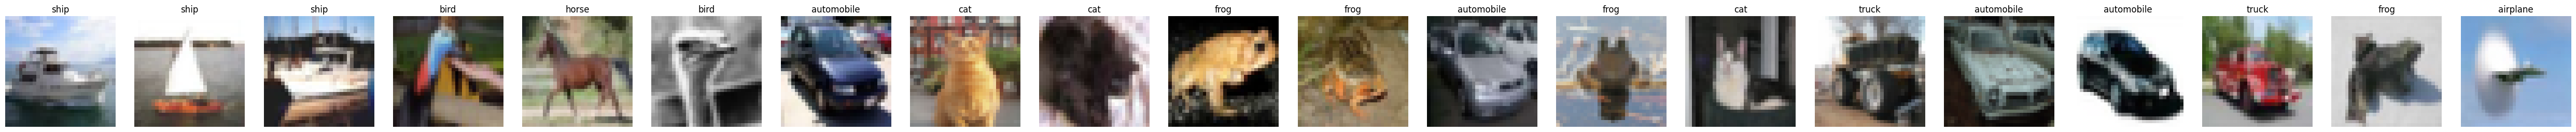

In [ ]:
def show_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(n*2.5, 2.5))
    for ax in axes:
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        # img: tensor [C,H,W] in [0,1]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # HWC
        ax.set_title(classes[label])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train_set, n=20)



> **Reflection (Markdown):** Describe CIFAR‑10 (resolution, channels, number of classes/samples). Include one sentence on why normalization is helpful for training.



## Compute Per‑Channel Mean & Standard Deviation



In [ ]:
BATCH_SIZE = 512
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

n_pixels = 0
channel_sum = torch.zeros(3)
channel_sq_sum = torch.zeros(3)

for imgs, _ in train_loader:
    # imgs: [B, 3, 32, 32] in [0,1]
    b = imgs.shape[0]
    n_pixels += b * imgs.shape[2] * imgs.shape[3]  # B*H*W
    channel_sum += imgs.sum(dim=[0, 2, 3])
    channel_sq_sum += (imgs ** 2).sum(dim=[0, 2, 3])

mean = channel_sum / n_pixels
std = torch.sqrt(channel_sq_sum / n_pixels - mean ** 2)

mean, std

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))


> Record your computed values here (e.g., `Mean ≈ [0.4914, 0.4822, 0.4465]`, `Std ≈ [0.2470, 0.2435, 0.2616]`). Your numbers should closely match these canonical references.



## Normalize Datasets Using Computed Stats


In [ ]:
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

train_set_norm = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=train_transform)
test_set_norm  = datasets.CIFAR10(root=DATA_DIR, train=False, download=False, transform=test_transform)

len(train_set_norm), len(test_set_norm)


(50000, 10000)


## Verify Normalization (Means ≈ 0, Stds ≈ 1)

Confirm the transformation worked as intended.


In [ ]:

train_loader_norm = DataLoader(train_set_norm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

mean_acc = torch.zeros(3)
sqmean_acc = torch.zeros(3)
npixels_total = 0

for imgs, _ in train_loader_norm:
    b = imgs.shape[0]
    npixels = b * imgs.shape[2] * imgs.shape[3]
    npixels_total += npixels
    mean_acc += imgs.sum(dim=[0,2,3])
    sqmean_acc += (imgs**2).sum(dim=[0,2,3])

mean_norm = mean_acc / npixels_total
var_norm = sqmean_acc / npixels_total - mean_norm**2
std_norm = torch.sqrt(var_norm + 1e-8)

mean_norm, std_norm


(tensor([ 6.3210e-08, -3.7668e-07, -3.9223e-07]),
 tensor([1.0000, 1.0000, 1.0000]))


> Report the post‑normalization means and stds. They should be close to `[0,0,0]` and `[1,1,1]` (small deviations are normal due to rounding/batching).



## Light Data Augmentation
Add a few basic augmentations (random crop with padding, random horizontal flip). Use **train** only.


In [ ]:

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    #anything else you may want to add is welcomed
    normalize,
])

train_set_aug = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=aug_transform)
len(train_set_aug)


50000



---


> Explain when/why augmentation helps. What risks do heavy augmentations pose for small images like CIFAR‑10 (32×32)?:

Augmentations could be very usefull when the dataset is limited or the real world can differ. Implement this transformations to the existing data such as flipping, cropping, rotating, and color distortions, could result in benefits like:



*   Improved generalization:  can help to improve a model’s generalization, because the model is exposed to more information of data.
*   Reduced overfitting: By making more diverse the data set the overfitting afer the training be significally reduced.
*   Reduced cost: Can reduce the cost when collect the data is
expensive or consume much time.

But also augmentation carries some riks specially with small images like this case, those risks are such as:



*   Potential for introducing noise: can introduce noise into the training data and can lead to reduce the perdormance.
*   Increased computational cost.




## Class Distribution
Confirm class balance. CIFAR‑10 should be balanced across the 10 classes. Create a plot as a visual aid


Class counts: {'airplane': np.int64(5000), 'automobile': np.int64(5000), 'bird': np.int64(5000), 'cat': np.int64(5000), 'deer': np.int64(5000), 'dog': np.int64(5000), 'frog': np.int64(5000), 'horse': np.int64(5000), 'ship': np.int64(5000), 'truck': np.int64(5000)}


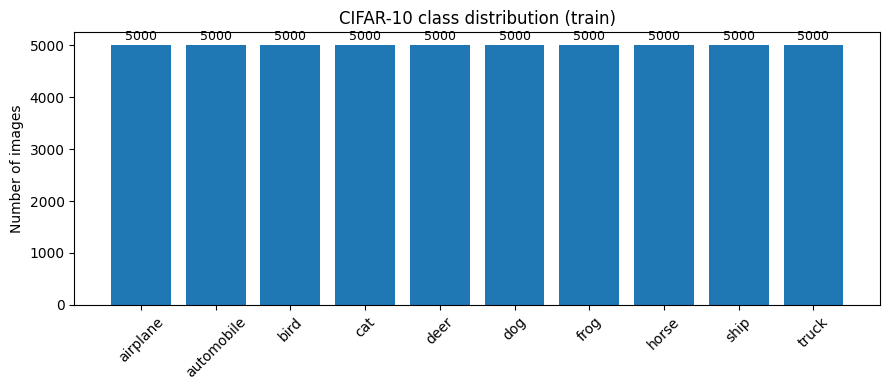

In [ ]:
'''
Cifar10 is perfectly distributed among classes, this will not always be the case, plots help, numbers help
'''

# show class distribution
# show plot

train_targets = np.array(train_set.targets if hasattr(train_set, "targets") else train_set.data[:, -1])
classes = train_set.classes

counts = np.bincount(train_targets, minlength=10)

print("Class counts:", dict(zip(classes, counts)))

# Plot
plt.figure(figsize=(9,4))
plt.bar(range(len(classes)), counts)
plt.xticks(range(len(classes)), classes, rotation=45)
plt.ylabel("Number of images")
plt.title("CIFAR-10 class distribution (train)")
# Anotar valores
for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


## 9. Submission Checklist
- [x] Printed dataset sizes and showed random sample images.
- [x] Reported per‑channel mean & std from the training set.
- [x] Applied normalization using computed stats.
- [x] Verified post‑normalization mean/std are ~0/1.
- [x] Basic augmentations and rationale.
